# RNA velocity analysis with scVelo

<div class="author_info" style='background-color:#f7d292; color: #050505; border: solid #f0a82e 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'>
<b>Introduction</b></p>
<p style='margin-left:1em;'>
This script is for performing RNA velocity analysis using <a href="https://scvelo.readthedocs.io/">scVelo</a>
</p>
<p style='margin-left:1em;'>
RNA velocity enables the recovery of directed dynamic information by leveraging splicing kinetics. scVelo generalizes the concept of RNA velocity (La Manno et al., Nature, 2018) by relaxing previously made assumptions with a stochastic and a dynamical model that solves the full transcriptional dynamics. It thereby adapts RNA velocity to widely varying specifications such as non-stationary populations.
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'> <b>Ceren Pajanoja</b> <i>(Feb,2022)</i>
</p></span>
</div>

In [ ]:
import scanpy as sc
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd
import scvelo as scv
import scanpy as sc
import cellrank as cr
import anndata as ad

#### Note:
<p> Make sure you have pandas version 1.3.5 for this pipeline, you can do it by running: <b>!pip install pandas==1.3.5 --user</b></p>

## Step-1: Convert Seurat object to Python
<i> Run this in Rstuido</i>
```Python
#save metadata table:
seurat_obj$barcode <- colnames(seurat_obj)
seurat_obj$UMAP_1 <- seurat_obj@reductions$umap@cell.embeddings[,1]
seurat_obj$UMAP_2 <- seurat_obj@reductions$umap@cell.embeddings[,2]
write.csv(seurat_obj@meta.data, file='metadata.csv', quote=F, row.names=F)

#write expression counts matrix
library(Matrix)
counts_matrix <- GetAssayData(seurat_obj, assay='RNA', slot='counts')
writeMM(counts_matrix, file=paste0(out_data_dir, 'counts.mtx'))
#write dimesnionality reduction matrix, in this example case pca matrix
write.csv(seurat_obj@reductions$pca@cell.embeddings, file='pca.csv'), quote=F, row.names=F)

#write gene names 
write.table(
  data.frame('gene'=rownames(counts_matrix)),file='gene_names.csv',
  quote=F,row.names=F,col.names=F
)
```

## Step-2a: Load your data from Seurat 

In [ ]:
# load sparse matrix:
X = io.mmread("counts.mtx")

# create anndata object
adata = anndata.AnnData(
    X=X.transpose().tocsr()
)

In [ ]:
# load cell metadata:
cell_meta = pd.read_csv("metadata.csv")

In [ ]:
# load gene names:
with open("gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()

In [ ]:
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

In [ ]:
# load dimensional reduction:
pca = pd.read_csv("pca.csv")
pca.index = adata.obs.index

In [ ]:
# set pca and umap
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

In [ ]:
# plot a UMAP colored by sampleID to test:
#SampleID = old.ident stage names
sc.pl.umap(adata, color=['old.ident'], frameon=False, save=True)

## Step-2b: Load your Loom files

In [ ]:
# Set up first
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False)
cr.settings.verbosity = 2

In [ ]:
# load loom files for spliced/unspliced matrices for each sample:
s_11 = scv.read('1som_1.loom', cache=True)
s_12 = scv.read('1som_2.loom', cache=True)
s_41 = scv.read('4som_1.loom', cache=True)
s_42 = scv.read('4som_2.loom', cache=True)
s_71 = scv.read('7som_1.loom', cache=True)
s_72 = scv.read('7som_2.loom', cache=True)
s_H51 = scv.read('HH5_1.loom', cache=True)
s_H52 = scv.read('HH5_2.loom', cache=True)

In [ ]:
# rename barcodes in order to merge:
barcodes = [bc.split(':')[1] for bc in s_11.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_s11' for bc in barcodes]
s_11.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in s_12.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_s12' for bc in barcodes]
s_12.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in s_41.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_s41' for bc in barcodes]
s_41.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in s_42.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_s42' for bc in barcodes]
s_42.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in s_71.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_s71' for bc in barcodes]
s_71.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in s_72.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_s72' for bc in barcodes]
s_72.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in s_H51.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_sH51' for bc in barcodes]
s_H51.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in s_H52.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_sH52' for bc in barcodes]
s_H52.obs.index = barcodes

In [ ]:
# make variable names unique
s_11.var_names_make_unique()
s_12.var_names_make_unique()
s_41.var_names_make_unique()
s_42.var_names_make_unique()
s_71.var_names_make_unique()
s_72.var_names_make_unique()
s_H51.var_names_make_unique()
s_H52.var_names_make_unique()

In [ ]:
# concatenate 8 loom files
ldata = s_11.concatenate([s_12, s_41,s_42,s_71,s_72,s_H51,s_H52])

In [ ]:
# merge matrices into the original adata object
adata = scv.utils.merge(adata, ldata)

In [ ]:
# plot umap to check
sc.pl.umap(adata, color='old.ident', frameon=False, legend_loc='on data', title='', save='_celltypes.pdf')

In [ ]:
# Here set a point for pseudotime, change starting cell variable into any number and check the results
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=2000)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)


In [ ]:
#this will give you proportions of spliced and unspliced RNA within your groups 
scv.pl.proportions(adata, groupby='old.ident',save='splice_ratio.pdf')


### Example Output:
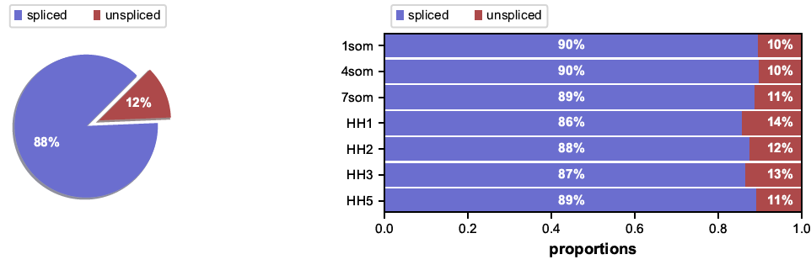

## Step-3: Pre-process

In [ ]:
# pre-process
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)

In [ ]:
# compute velocity
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

### Visualize velocity fields

In [ ]:
scv.pl.velocity_embedding(adata, basis='umap', frameon=False, save='embedding.pdf')

In [ ]:
#Edit the color palette to your liking
scv.pl.velocity_embedding_grid(adata, basis='umap' ,color='old.ident',palette=['#fa7148','#4cd2ff','#2f7cff','#e6c029'], save='embedding_grid.pdf', title='', scale=0.25)


In [ ]:
# This velocity will create average velocity
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['old.ident'], save='embedding_stream.pdf',
                                 palette=['#fa7148','#4cd2ff','#2f7cff','#e6c029'],title='')

In [ ]:
# plot velocity of a selected gene
scv.pl.velocity(adata, var_names=['TFAP2A','Pou5f3','NANOG'], color='old.ident',save='Fig3E.pdf')

### Example Output:
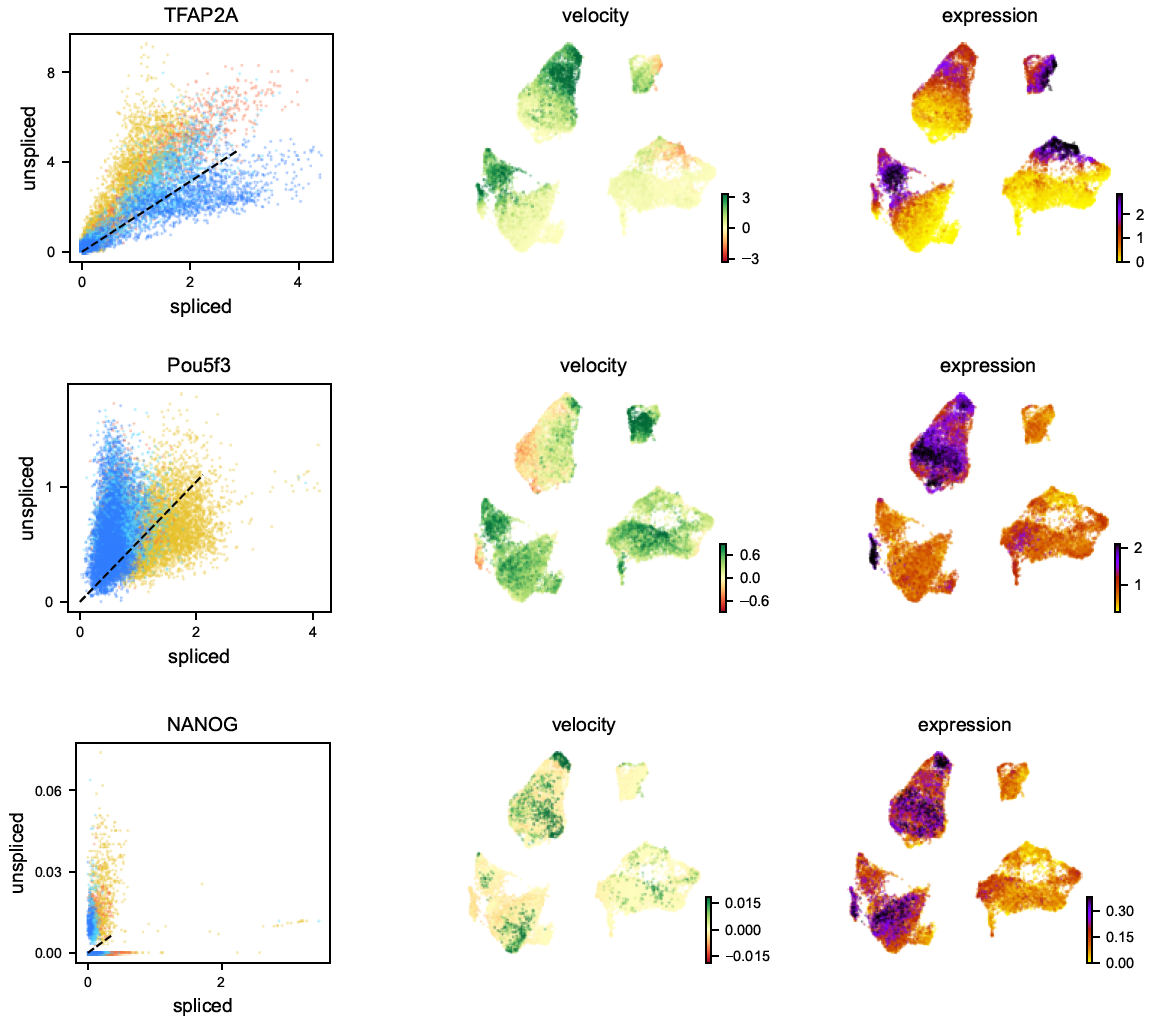